<a href="https://colab.research.google.com/github/SenaKymk/naive_bayes_YZM212_lab/blob/main/LogisticRegression/logisticRegressionManuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Manual Logistic Regression Modeli

Bu bölümde, Logistic Regression algoritması **kütüphane kullanmadan** sıfırdan Python ile manuel olarak uygulanacaktır.

Amaç: Gradient Descent kullanarak ağırlıkları öğrenmek ve sigmoid fonksiyonunu kullanarak sınıflandırma yapmak.

Bu çalışmada, UCI Mushroom veri seti kullanılarak Logistic Regression uygulanmıştır. Amaç, mantarların fiziksel özelliklerine göre zehirli (poisonous) veya yenilebilir (edible) olup olmadığını tahmin etmektir.



In [24]:
!pip install ucimlrepo

In [25]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [26]:
mushroom = fetch_ucirepo(id=73)

X = mushroom.data.features
y = mushroom.data.targets
df = pd.DataFrame(data=mushroom.data.features)
df['target'] = mushroom.data.targets

In [27]:
if df.isna().any().any():
  df.dropna(inplace=True)
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,target
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [28]:
from sklearn.preprocessing import LabelEncoder

# Tüm kolonlara Label Encoding uygula
label_encoder = LabelEncoder()
df_encoded = df.apply(label_encoder.fit_transform)
df_encoded.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,target
0,5,2,4,1,6,1,0,1,2,0,...,5,5,0,0,1,3,1,3,5,1
1,5,2,7,1,0,1,0,0,2,0,...,5,5,0,0,1,3,2,2,1,0
2,0,2,6,1,3,1,0,0,3,0,...,5,5,0,0,1,3,2,2,3,0
3,5,3,6,1,6,1,0,1,3,0,...,5,5,0,0,1,3,1,3,5,1
4,5,2,3,0,5,1,1,0,2,1,...,5,5,0,0,1,0,2,0,1,0


In [29]:
# Target (bağımlı değişken) sütunu 'target'
y = df_encoded['target']

# Geri kalanlar bağımsız değişken (features)
X = df_encoded.drop('target', axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



##  Sigmoid Fonksiyonunun Tanımlanması

Sigmoid fonksiyonu, Logistic Regression'ın temelidir.
Lineer regresyon sonucunu **0 ile 1 arasına** sıkıştırır ve olasılık üretir.

\[
sigmoid(z) = \frac{1}{1 + e^{-z}}
\]


In [31]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


##  Loss Fonksiyonunun Tanımlanması (Binary Cross-Entropy)

Modelin ne kadar iyi öğrendiğini ölçmek için Binary Cross-Entropy Loss fonksiyonu kullanılmıştır.

\[
Loss = -\frac{1}{N} \sum (y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}))
\]


In [32]:
def compute_loss(y, y_pred):
    epsilon = 1e-8  # log(0) hatası önlemek için
    return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))


##  Gradient Descent Algoritması ile Model Eğitimi

Her iterasyonda ağırlıklar ve bias değerleri güncellenir.
Bu işlem belirlenen epoch sayısı kadar devam eder.

Öğrenme oranı (**learning rate**) ağırlıkların güncellenme hızını belirler.


In [33]:
def train_log_reg(X, y, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    loss_history = []

    for epoch in range(epochs):
        # Lineer kombinasyon ve sigmoid
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)

        # Gradientler
        dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
        db = (1 / n_samples) * np.sum(y_pred - y)

        # Ağırlık güncelle
        weights -= lr * dw
        bias -= lr * db

        if epoch % 100 == 0:
            loss = compute_loss(y, y_pred)
            loss_history.append(loss)

    return weights, bias, loss_history


In [34]:
def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return np.where(y_pred >= 0.5, 1, 0)


In [35]:
X_np = X_train.to_numpy()
y_np = y_train.to_numpy()

weights, bias, loss_hist = train_log_reg(X_np, y_np, lr=0.1, epochs=2000)


In [36]:
y_pred_manual = predict(X_test.to_numpy(), weights, bias)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_test, y_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_manual))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       705
           1       0.93      0.89      0.91       424

    accuracy                           0.93      1129
   macro avg       0.93      0.92      0.93      1129
weighted avg       0.93      0.93      0.93      1129

Confusion Matrix:
 [[676  29]
 [ 47 377]]


In [37]:
# Performans ölçümleri
accuracy = accuracy_score(y_test, y_pred_manual)
print(f"Accuracy: {accuracy:.4f}\n")

Accuracy: 0.9327



In [38]:
import time
start = time.time()
weights, bias, _ = train_log_reg(X_np, y_np, lr=0.1, epochs=2000)
train_time = time.time() - start

start_test = time.time()
y_pred_manual = predict(X_test.to_numpy(), weights, bias)
test_time = time.time() - start_test

print(f"Eğitim Süresi: {train_time:.4f} saniye")
print(f"Test Süresi: {test_time:.4f} saniye")


Eğitim Süresi: 1.3743 saniye
Test Süresi: 0.0005 saniye


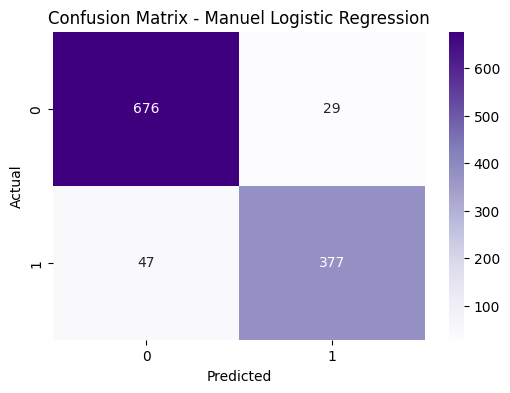

In [39]:
# Karmaşıklık Matrisi Görselleştirmesi
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_manual), annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Manuel Logistic Regression")
plt.show()

# 📈 **Genel Yorum:**

Manuel Logistic Regression modeli başarılı bir sonuç vermiştir ve %93.27 doğruluk ile test verisini sınıflandırmıştır.

Precision ve Recall değerleri dengeli fakat:

Recall (zehirli sınıf için) biraz daha düşük  0.89

Bu, modelin bazı zehirli mantarları "yenilebilir" olarak tahmin ettiği anlamına gelir (False Negative = 47).

Edible (0) sınıfında başarı daha yüksek  Recall 0.96

**Manuel Logistic Regression modeli, scikit-learn modeline yakın performans göstermiştir.**

Eğitim ve test süreleri kabul edilebilir seviyede hızlıdır.

Ancak zehirli sınıf için Recall düşük kaldığından, daha fazla iterasyon veya farklı bir optimizasyon yöntemi denenebilir.